In [53]:
from pathlib import Path
import os
import sys
if str(Path.cwd().parent) not in sys.path:
    sys.path.append(str(Path.cwd().parent))
    from cycler import cycler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from settings.paths import img_path, rf_path, bnn_path, flex_path
from utils.metrics import rmse, out_frac


plt.rcParams["font.size"] = 22
blue = (0, 0.48, 0.70)
orange = (230/255,159/255, 0)
yellow = (0.94, 0.89, 0.26)
pink = (0.8, 0.47, 0.65)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.rcParams['axes.prop_cycle'] = cycler('color', CB_color_cycle)


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
list_feat = ["broad", "broad+narrow", "broad+GALEX+WISE", "broad+GALEX+WISE+narrow"]
color_feat = {}
color_feat["broad"] = "#377eb8"
color_feat["broad+narrow"] =  "#ff7f00"
color_feat["broad+GALEX+WISE"]= "#4daf4a"
color_feat["broad+GALEX+WISE+narrow"]= "#f781bf"

In [55]:
z = {}
for feat in list_feat:
    print(feat)
    if "GALEX" and "WISE" in feat:
        z[feat] = pd.read_csv(os.path.join(rf_path, "val_z_"+feat+"+flags.csv"), index_col=0)
    else:
        z[feat] = pd.read_csv(os.path.join(rf_path, "val_z_"+feat+".csv"), index_col=0)
        


broad
broad+narrow
broad+GALEX+WISE
broad+GALEX+WISE+narrow


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


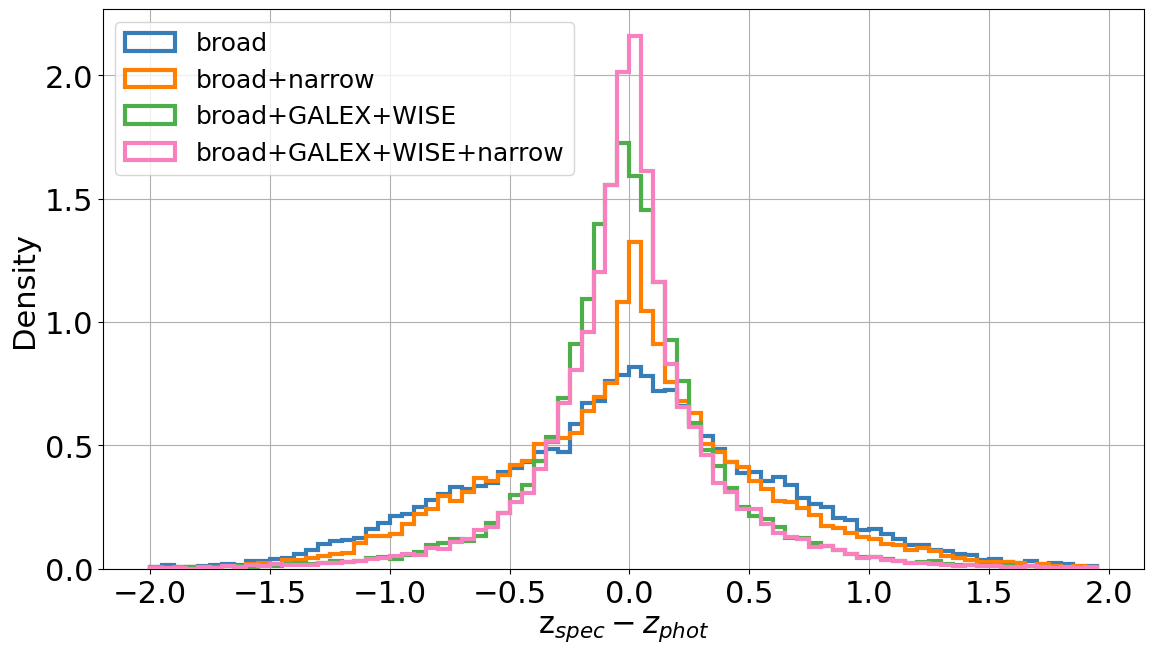

In [36]:
plt.figure(figsize=(12,7))
bins = np.arange(-2,2,0.05)
for key, model in z.items():
    plt.hist(z[key].Z - z[key].z_pred, bins = bins,  zorder=10,alpha=1, histtype="step" , linewidth=3, label= key, density=True)
plt.grid(zorder=0)
plt.ylabel("Density")
plt.xlabel(r"z$_{spec}-z_{phot}$")
plt.legend(prop={'size': 18}, loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(img_path,"residuals_all.png"))
plt.savefig(os.path.join(img_path,"residuals_all.eps"), format='eps')

# plt.ylim(0,2.2)
plt.show()

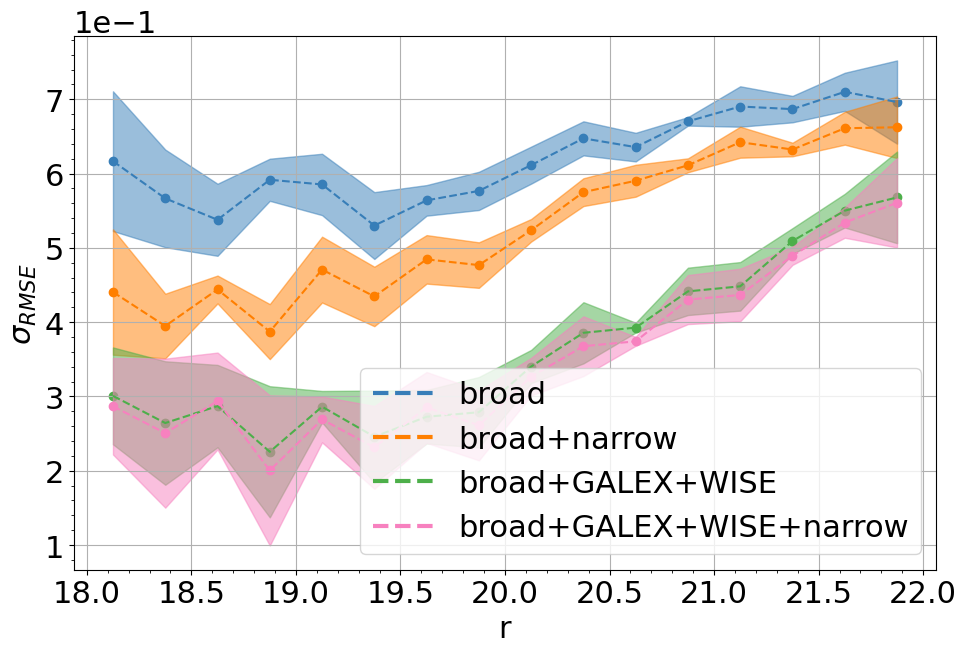

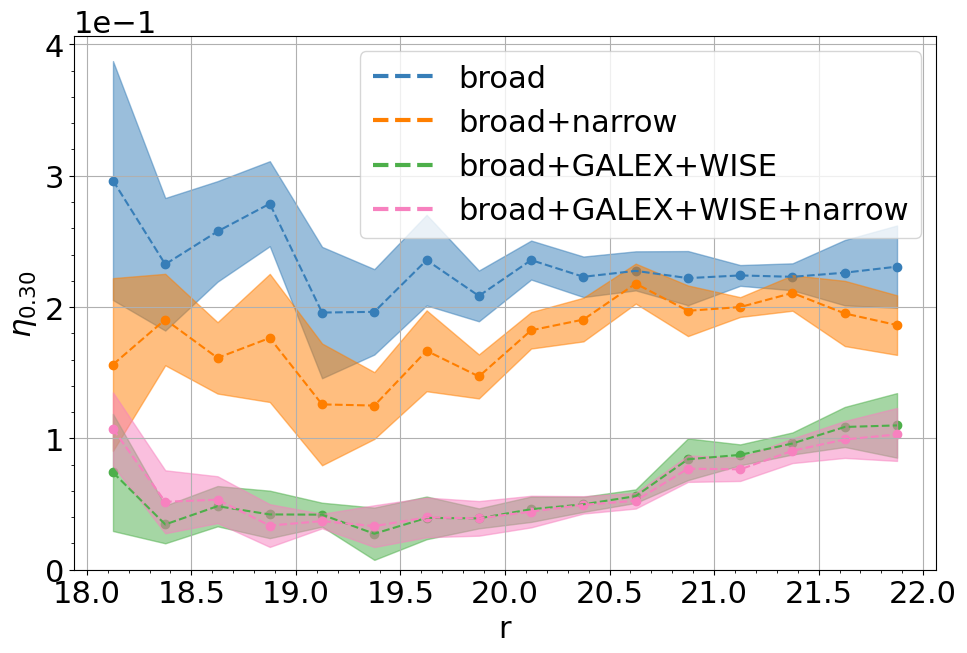

In [71]:
from utils.plots import plot_metric_per_bin

std=True
bins = np.arange(18, 22.2, 0.25)
plot_metric_per_bin(list_feat,z, rmse, color_feat = color_feat, std=std, bins = bins, save=False)
plot_metric_per_bin(list_feat,z, out_frac, color_feat = color_feat,  std=std, bins = bins, save=False)


In [48]:
from utils.plots import plot_metric_per_bin, metrics_bin

In [61]:
bins = np.arange(18, 22.2, 0.25)
metrics_bin(z[feat], rmse, bins = bins, var="r_PStotal")

,bins,n,rmse_median,rmse_std
0,18.125,154,0.286806,0.064973
1,18.375,242,0.250611,0.100301
2,18.625,355,0.293877,0.065162
3,18.875,580,0.200425,0.101009
4,19.125,736,0.269075,0.030825
5,19.375,1032,0.231484,0.055740
6,19.625,1282,0.285223,0.047635
7,19.875,1573,0.261125,0.047086
8,20.125,1936,0.326582,0.025279
9,20.375,2156,0.367636,0.040180
